# MLBデータ探索
- [MLBデータサイトの統計データ](http://www.seanlahman.com/baseball-archive/statistics/)から「Download 2016 Version」「2016 – comma-delimited version」を取得
- この中から、データ探索対象をTeams.csvに絞る

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

mlb_team = pd.read_csv('./core/Teams.csv')

# ①最も勝利数に貢献するのは何か？
- 各年で、勝利数に最も強く正の相関を示す列名を出す。例えば、１８７１年は得点'R'
- 上で出した列名毎にyearIDをカウントし、多い順に３つ出してみた　　

In [2]:
# 'yearID'列をとりだし、全行を一旦リストにして、その後、
# 集合にして重複を無くしてから、再びリストにする
col = 'yearID'
cuts = list(set(mlb_team[[col]].values.flatten()))

# col_factorsリストに、
# 各年と、各年毎に勝利数に最も強く正の相関を示す列名を格納する
col_factors = []
for cut in cuts:
    cut_mlb_team = mlb_team[mlb_team[col].isin([cut])]
    col_factors.append([str(cut), cut_mlb_team.corr().loc['W'].drop(['W']).\
                    sort_values(ascending=False).head(1).index.values[0]])

# 上記で格納した列名を'the　Factors'としてgroupby。
# col_factorsリスト内の個数を集計し、多い順に３つ出す
pd.DataFrame(col_factors).rename(columns={0: col, 1: 'the Factors'}).\
groupby(['the Factors']).count().sort_values(by=col, ascending=False).head(3)

,yearID
the Factors,
R,64
attendance,28
SV,19


1位が得点'R'はいかにもだが、2位がホーム観客総動員数'attendance'は意外に感じた。  
3位が「救援投手が最後までリードを守りきった回数」'SV'、投手の力量を測る重要指標  

# ②最もattendanceに貢献するのは何か？
- 勝利数の場合と同様にして、多い順に３つ出してみた
- また、最も強く負の相関を示すものについても出してみた

In [3]:
# 'yearID'列をとりだし、全行を一旦リストにして、その後、
# 集合にして重複を無くしてから、再びリストにする
col = 'yearID'
cuts = list(set(mlb_team[[col]].values.flatten()))

# col_factorsリストに、
# 各年と、各年毎にattendanceに最も強く正の相関を示す列名を格納する
col_factors = []
for cut in cuts:
    cut_mlb_team = mlb_team[mlb_team[col].isin([cut])]
    col_factors.append([str(cut), cut_mlb_team.corr().loc['attendance'].\
                        drop(['attendance']).sort_values(ascending=False).\
                        head(1).index.values[0]])

# 上記で格納した列名を'the　Factors'としてgroupby。
# col_factorsリスト内の個数を集計し、多い順に３つ出す
pd.DataFrame(col_factors).rename(columns={0: col, 1: 'the Factors'}).\
groupby(['the Factors']).count().sort_values(by=col, ascending=False).head(3)

,yearID
the Factors,
W,65
yearID,19
HR,7


In [4]:
# 'yearID'列をとりだし、全行を一旦リストにして、その後、
# 集合にして重複を無くしてから、再びリストにする
col = 'yearID'
cuts = list(set(mlb_team[[col]].values.flatten()))

# col_factorsリストに、
# 各年と、各年毎にattendanceに最も強く負の相関を示す列名を格納する
col_factors = []
for cut in cuts:
    cut_mlb_team = mlb_team[mlb_team[col].isin([cut])]
    col_factors.append([str(cut), cut_mlb_team.corr().loc['attendance'].\
                        drop(['attendance']).sort_values(ascending=False).\
                        tail(1).index.values[0]])

# 上記で格納した列名を'the　Factors'としてgroupby。
# col_factorsリスト内の個数を集計し、多い順に３つ出す
pd.DataFrame(col_factors).rename(columns={0: col, 1: 'the Factors'}).\
groupby(['the Factors']).count().sort_values(by=col, ascending=False).head(3)

,yearID
the Factors,
SF,100
PPF,19
yearID,14


1位はやっぱり勝利数'W'。2位が年'yearID'というのは、勝利数以外の項目がほとんど相関していないということか。あるいは、年毎にばらけているのだろう。  
ところで、逆に最もattendanceに対して負の相関を示す項目をみてみると、犠牲フライ'SF'がダントツの１位。来場者を増やしたければ、犠牲フライはやらない方がいい、ということか

# ③MLB全体の、attendance推移は？

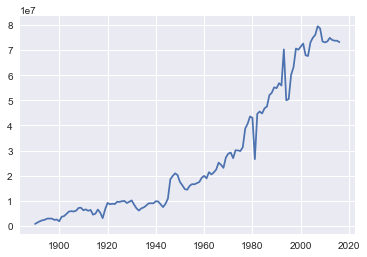

In [5]:
year_atte = mlb_team[['yearID', 'attendance']].\
groupby(['yearID'], as_index=False).sum().dropna()

plt.plot(year_atte[['yearID']], year_atte[['attendance']])

大局的には上昇が続いていたが、２０１０年の少し前をピークに横ばいの傾向が見て取れる

# ④MLB全体の、守備率(Fielding  percentage)推移は？

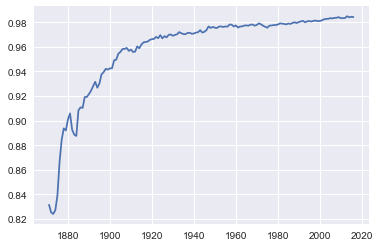

In [6]:
year_fp = mlb_team[['yearID', 'FP']].\
groupby(['yearID'], as_index=False).mean().dropna()

plt.plot(year_fp[['yearID']], year_fp[['FP']])

１８００年代末期から１９００年代初期にかけて急激に良くなる。以後は緩やかな上昇傾向

# ⑤勝利数と集客力(attendance)の二軸で、各チームを比較
- 縦軸は集客数平均、横軸は勝利数平均、各点注釈をチームIDとして、散布図を描く

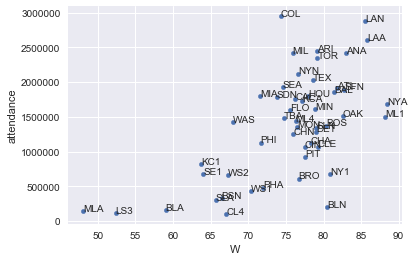

In [7]:
# teamIDを芯にして、各チームの勝利数平均、集客数平均を結合。面倒なのでdropna
team_win = mlb_team[['teamID', 'W']].groupby(['teamID']).mean()
team_atte = mlb_team[['teamID', 'attendance']].groupby(['teamID']).mean()
team_win_atte = team_win.join(team_atte, how='inner').dropna()

# 散布図を描画。indexを各要素のラベルとして貼る
scat = team_win_atte.plot.scatter(x='W',y='attendance')
for i, j in team_win_atte.iterrows():
    scat.annotate(i, xy=(j[0],j[1]), size=10)

さすがに、右上に有名どころが集中している。
- LAN: Los Angeles Dodgers  
- LAA: Los Angeles Angels of Anaheim  
- COL: Colorado Rockies  
- NYA: New York Yankees  
- ML1: Milwaukee Braves

# ⑥エラー数とヒット数の二軸で、一般チームとWS勝者チームを比較
- 縦軸はエラー数、横軸はヒット数として、散布図を描く。向かって左が一般、右が勝者

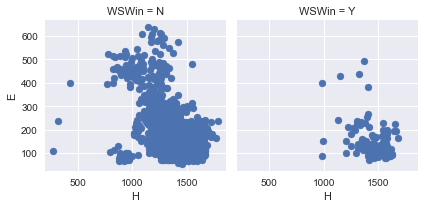

In [8]:
grid = sns.FacetGrid(mlb_team[['WSWin', 'H', 'E']].dropna(), \
                     col='WSWin', size=3, aspect=1)
grid.map(plt.scatter, 'H', 'E')

勝者チームは、エラーが少なく、ヒットが多い。まともな結果

# ⑦盗塁成功数と盗塁失敗数の二軸で、一般チームとWS勝者チームを比較
- 縦軸は盗塁成功数、横軸は盗塁失敗数として、散布図を描く。向かって左が一般、右が勝者

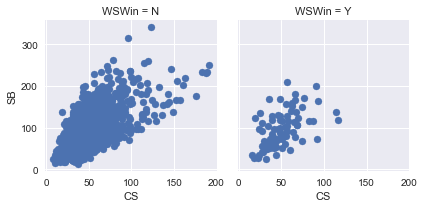

In [9]:
grid = sns.FacetGrid(mlb_team[['WSWin', 'CS', 'SB']].dropna(), \
                     col='WSWin', size=3, aspect=1)
grid.map(plt.scatter, 'CS', 'SB')

勝者チームは、盗塁成功も盗塁失敗も若干少ない。あまり盗塁しないのが勝者の秘訣か